<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


#### Tutorial 1.2: Introduction to GWpy

This tutorial will briefly describe GWpy, a python package for gravitational astrophysics, and walk-through how you can use this to speed up access to, and processing of, GWOSC data.
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_1/Tuto%201.2%20Open%20Data%20access%20with%20GWpy.ipynb)

<div class="alert alert-info">This notebook were generated using python 3.7, but should work on python 2.7, 3.6, or 3.7.</div>

##  Installation  (execute only if running on a cloud platform or if you haven't done the installation already!)

Note: we use [`pip`](https://docs.python.org/3.6/installing/), but **it is recommended** to use [conda](https://docs.ligo.org/lscsoft/conda/) on your own machine, as explained in the [installation instructions](https://github.com/gw-odw/odw-2019/blob/master/setup.md). This usage might look a little different than normal, simply because we want to do this directly from the notebook.

In [17]:
# -- Uncomment following line if running in Google Colab
#! pip install -q 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [18]:
import gwpy
print(gwpy.__version__)

1.0.1


## A note on object-oriented programming

Before we dive too deeply, its worth a quick aside on object-oriented programming (OOP).
GWpy is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/).

## Handling data in the time domain

### Finding open data

We have seen already that the `gwosc` module can be used to query for what data are available on GWOSC.
The next thing to do is to actually read some open data. Let's try to get some for GW170817, the first direct detection of an astrophysical gravitational-wave signal from a BNS (binary neutron star system).

We can use the [`TimeSeries.fetch_open_data`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fetch_open_data) method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times.
We can query for the GPS time of an event as follows:

In [19]:
from gwosc.datasets import event_gps
gps = event_gps('GW170817')
print(gps)

1187008882.4


Now we can build a `[start, end)` GPS segment to 10 seconds around this time, using integers for convenience:

In [20]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1187008877, 1187008887)


and can now query for the full data.
For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `'L1'`.
We could have chosen any of

- `'G1`' - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo

In the future, the Japanese observatory KAGRA will come online, with the identifier `'K1'`.

In [21]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(hdata)

Fetched 1 URLs from www.gw-osc.org for [1187008877 .. 1187008887))
Reading data... [Done]
TimeSeries([1.28236790e-19, 1.19758281e-19, 1.25450032e-19, ...,
            6.43515284e-20, 6.80497504e-20, 6.83906719e-20]
           unit: dimensionless,
           t0: 1187008877.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


The `verbose=True` flag lets us see that GWpy has discovered two files that provides the data for the given interval, downloaded them, and loaded the data.
The files are not stored permanently, so next time you do the same call, it will be downloaded again, however, if you know you might repeat the same call many times, you can use `cache=True` to store the file on your computer.

Notes: 

* To read data from a local file instead of from the GWOSC server, we can use [`TimeSeries.read`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.read) method.

We have now downloaded real LIGO data for GW170817! These are the actual data used in the analysis that discovered the first binary neutron star merger.

To sanity check things, we can easily make a plot, using the [`plot()`](https://gwpy.github.io/docs/stable/timeseries/plot.html) method of the `data` `TimeSeries`.

<div class="alert alert-info">
Since this is the first time we are plotting something in this notebook, we need to make configure `matplotlib` (the plotting library) to work within the notebook properly:
</div>

Matplotlib documentation can be found [`here`](https://matplotlib.org/contents.html).

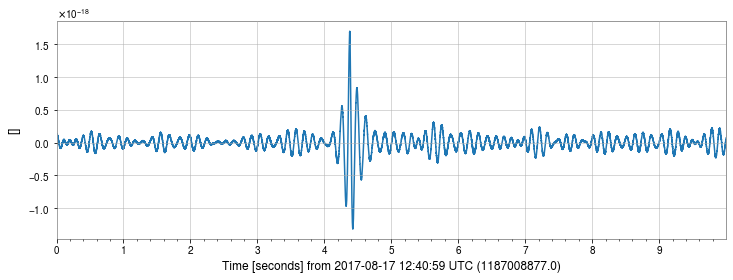

In [22]:
%matplotlib inline
plot = hdata.plot()

Notes: There are alternatives ways to access the GWOSC data. 

* [`readligo`](https://losc.ligo.org/s/sample_code/readligo.py) is a light-weight Python module that returns the time series into a Numpy array.
* The [PyCBC](http://github.com/ligo-cbc/pycbc) package has the `pycbc.frame.query_and_read_frame` and `pycbc.frame.read_frame` methods. We use [PyCBC](http://github.com/ligo-cbc/pycbc) in Tutorial 2.1, 2.2 and 2.3. 

## Quiz Question 1:

- The peak amplitued in the LIGO-Livingston data occurs at approximately 4.4 seconds into the plot above and is clearly above the background noise at a value of approximately 1.8x10^-18. Plot the data for the LIGO-Hanford detector around GW170817. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? 

## Handling data in the frequency domain using the Fourier transform

The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contian lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [`fft()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft) method:

In [23]:
fft = hdata.fft()
print(fft)

FrequencySeries([-1.73578437e-22+0.00000000e+00j,
                 -3.50314468e-22+1.12549788e-23j,
                 -3.67114959e-22+5.54275241e-23j, ...,
                  1.70587778e-24+6.36053412e-26j,
                  1.65990114e-24+4.75594623e-26j,
                  1.71450418e-24+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1187008877.0,
                name: Strain,
                channel: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/frequencyseries/), with complex amplitude, representing the amplitude and phase of each frequency in our data.
We can use `abs()` to extract the amplitude and plot that:

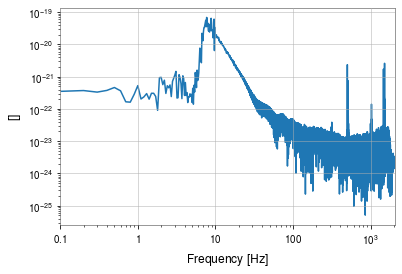

In [24]:
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

This doesn't look correct at all!
The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed.
We need to apply a window function to our time-domain data before transforming, which we can do using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module:

In [25]:
from scipy.signal import get_window
window = get_window('hann', hdata.size)
hwin = hdata * window

Let's try our transform again and see what we get

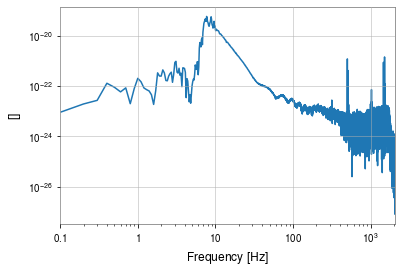

In [26]:
fftamp = hwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

This looks a little more like what we expect for the amplitude spectral density of a gravitational-wave detector.

## Calculating the power spectral density

In practice, we typically use a large number of FFTs to estimate an averages power spectral density over a long period of data.
We can do this using the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) method, which uses [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to combine FFTs of overlapping, windowed chunks of data.

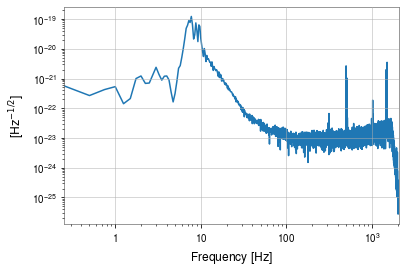

In [27]:
asd = hdata.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show(warn=False)

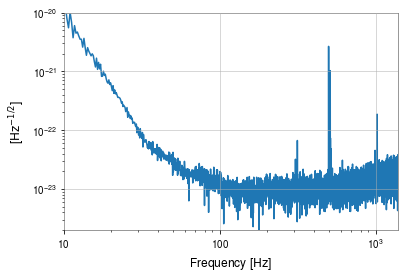

In [28]:
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
plot

The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
For the LIGO-Hanford data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

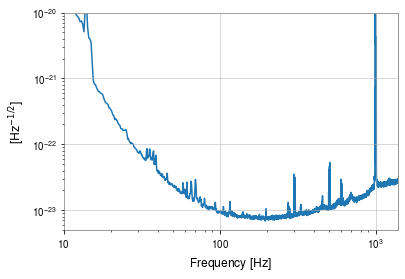

In [29]:
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")
plot = hasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(5e-24, 1e-20)
plot.show(warn=False)

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolate lines through the more sensitive region.

For comparison, we can load the LIGO-Livingston data and plot that as well:

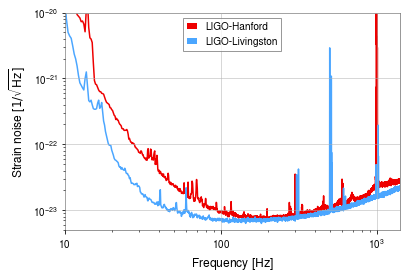

In [30]:
# get Livingston data
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(lasd2, label='LIGO-Livingston', color='gwpy:ligo-livingston')

# update the Hanford line to use standard colour, and have a label
hline = ax.lines[0]
hline.set_color('gwpy:ligo-hanford')  # change colour of Hanford data
hline.set_label('LIGO-Hanford')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory.

## Quiz Question 2:
Now that we have learnt how to download the data, do FFT & plot the asd using 'hann' window, you can do a very quick check. Take a different window namely a rectangular window or 'boxcar' as it is called in scipy. Try to perform FFT of the data with this window. See what you get. Does it serve our purpose ? Think about it.

